<a href="https://colab.research.google.com/github/KuJoJoTaRo2019/HaveFun/blob/master/Project2_short_semester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project2 is Deep Learning.**

~~Ohhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh Deep Learning Comes!~~

Actually it's just a little example for teaching.

Calm down and LEARN MORE.

---

In [ ]:
import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt
from matplotlib import rcParams 
import tensorflow as tf
import os, requests
from PIL import Image 
import zipfile
import cv2

##**Perceptron**

In [ ]:
# AND gate
def AND(x1,x2):
  x = np.array([x1,x2])
  w = np.array([0.5,0.5])
  b = -0.7
  tmp = np.sum(w*x) + b
  if tmp <= 0:
    return 0
  else:
    return 1

# NAND gate
def NAND(x1,x2):
  x = np.array([x1,x2])
  w = np.array([-0.5,-0.5])
  b = 0.7
  tmp = np.sum(w*x) + b
  if tmp <= 0:
    return 0
  else:
    return 1

# OR gate
def OR(x1,x2):
  x = np.array([x1,x2])
  w = np.array([1.0,1.0])
  b = -0.5
  tmp = np.sum(w*x) + b
  if tmp <= 0:
    return 0
  else:
    return 1

# XOR gate
def XOR(x1,x2):
  s1 = NAND(x1,x2)
  s2 = OR(x1,x2)
  y = AND(s1,s2)
  return y

# Note
# 1. Weight can be tuned for other meaning.
# 2. XOR gate can't be constructed by one-layer Perceptron.
# 3. Theoretically, two-layer Perceptron can equal to any function.
# 4. Weight and Bias are decided by human.

In [ ]:
# Test
def aTest(f):
  print('0 '+f.__name__+' 0 = '+str(f(0,0)))
  print('0 '+f.__name__+' 1 = '+str(f(0,1)))
  print('1 '+f.__name__+' 0 = '+str(f(1,0)))
  print('1 '+f.__name__+' 1 = '+str(f(1,1)))
  print()
aTest(AND)
aTest(NAND)
aTest(OR)
aTest(XOR)

0 AND 0 = 0
0 AND 1 = 0
1 AND 0 = 0
1 AND 1 = 1

0 NAND 0 = 1
0 NAND 1 = 1
1 NAND 0 = 1
1 NAND 1 = 0

0 OR 0 = 0
0 OR 1 = 1
1 OR 0 = 1
1 OR 1 = 1

0 XOR 0 = 0
0 XOR 1 = 1
1 XOR 0 = 1
1 XOR 1 = 0



##**SimpleNet and TwoLayerNet**

In [ ]:
#@title derivation function
def numerical_diff(f,x):
  h = 10e-50
  return (f(x+h)-f(x))/h

def numerical_diff_centre(f,x):
  h = 1e-4
  return (f(x +h)-f(x -h))/(2*h)


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 还原值
        it.iternext()   
        
    return grad

In [ ]:
#@title basic function
def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 溢出对策
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
#@title simpleNet
class SimpleNet:
  def __init__(self):
    self.W = np.random.rand(2,3) # initialize using Gaussian distribution
    self.alpha = 1

  def predict(self,x):
    return np.dot(x,self.W)

  def loss(self,x,t):
    z = self.predict(x)
    y = softmax(z)
    loss = cross_entropy_error(y,t)
    return loss

In [ ]:
#@title class Layers(Relu, Sigmoid, affine, SoftmaxWithLoss)
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        # 对应张量
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmax的输出
        self.t = None # 监督数据

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 监督数据是one-hot-vector的情况
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [ ]:
#@title class TwoLayerNet
class TwoLayerNet:
  def __init__(self,input_size,hidden_size,output_size,weight_init_std=0.01):
    self.params={}
    # 初始化参数
    self.params['W1'] = weight_init_std * np.random.randn(input_size,hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size,output_size)
    self.params['b2'] = np.zeros(output_size)

    # 构建两层网络
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'],self.params['b1'])
    self.layers['ReLu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'],self.params['b2'])
    self.lastLayer = SoftmaxWithLoss()


  def predict(self,x): 
    for layer in self.layers.values():
      x = layer.forward(x)
    return x

  def loss(self,x,t):
    y = self.predict(x)
    return self.lastLayer.forward(y,t)

  def accuracy(self,x,t):
    y = self.predict(x)
    y = np.argmax(y,axis=1)
    if t.ndim != 1:
      t = np.argmax(t,axis=1)
    accuracy = np.sum(y==t)/float(x.shape[0])
    return accuracy

  def numerical_gradient(self,x,t): # 这里做了修改，原始代码有误
    grads = {}
    grads['W1'] = self.calculate(x,t,'W1')
    grads['b1'] = self.calculate(x,t,'b1')
    grads['W2'] = self.calculate(x,t,'W2')
    grads['b2'] = self.calculate(x,t,'b2')
    return grads

  def calculate(self,x,t,stringW):
    h = 1e-4
    grad = np.zeros_like(self.params[stringW])
    it = np.nditer(self.params[stringW], flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
      idx = it.multi_index
      init_val = self.params[stringW][idx]
      self.params[stringW][idx] =  init_val + h # 让它在该处 + h
      v1 = self.loss(x,t)
      self.params[stringW][idx] =  init_val - h # 让它在该处 - h
      v2 = self.loss(x,t)
      self.params[stringW][idx] = init_val # 回复原值
      grad[idx] = (v1-v2)/(2*h)
    
    return grad

  def gradient(self,x,t):
    # forward
    self.loss(x,t)

    # backward
    dout = 1
    dout = self.lastLayer.backward(dout) # 从最后一层开始计算，获得对每一层的导数

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    grads = {}
    grads['W1'] , grads['b1'] = self.layers['Affine1'].dW , self.layers['Affine1'].db
    grads['W2'] , grads['b2'] = self.layers['Affine2'].dW , self.layers['Affine2'].db
    return grads
                                                                        

In [ ]:
#@title Load mnist data
# coding: utf-8
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path
import gzip
import pickle
import os
import numpy as np


url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dataset_dir = os.path.dirname(os.path.abspath('/content/sample_data'))
save_file = dataset_dir + "/mnist.pkl"

train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784


def _download(file_name):
    file_path = dataset_dir + "/" + file_name
    
    if os.path.exists(file_path):
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name, file_path)
    print("Done")
    
def download_mnist():
    for v in key_file.values():
       _download(v)
        
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)
    print("Done")
    
    return labels

def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name
    
    print("Converting " + file_name + " to NumPy Array ...")    
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)
    print("Done")
    
    return data
    
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])
    dataset['train_label'] = _load_label(key_file['train_label'])    
    dataset['test_img'] = _load_img(key_file['test_img'])
    dataset['test_label'] = _load_label(key_file['test_label'])
    
    return dataset

def init_mnist():
    download_mnist()
    dataset = _convert_numpy()
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T
    

def load_mnist(normalize=True, flatten=True, one_hot_label=False):
    """读入MNIST数据集
    
    Parameters
    ----------
    normalize : 将图像的像素值正规化为0.0~1.0
    one_hot_label : 
        one_hot_label为True的情况下，标签作为one-hot数组返回
        one-hot数组是指[0,0,1,0,0,0,0,0,0,0]这样的数组
    flatten : 是否将图像展开为一维数组
    
    Returns
    -------
    (训练图像, 训练标签), (测试图像, 测试标签)
    """
    if not os.path.exists(save_file):
        init_mnist()
        
    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)
    
    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0
            
    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])
    
    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label']) 


if __name__ == '__main__':
    init_mnist()


Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


train_acc,test_acc|0.13281666666666667,0.1301
train_acc,test_acc|0.9041166666666667,0.907
train_acc,test_acc|0.9197333333333333,0.9222
train_acc,test_acc|0.9322,0.9325
train_acc,test_acc|0.9403166666666667,0.939
train_acc,test_acc|0.9495333333333333,0.9493
train_acc,test_acc|0.9553833333333334,0.9525
train_acc,test_acc|0.9596,0.9578
train_acc,test_acc|0.9644833333333334,0.9615
train_acc,test_acc|0.966,0.9615
train_acc,test_acc|0.9687,0.963
train_acc,test_acc|0.9712333333333333,0.9657
train_acc,test_acc|0.9736333333333334,0.9676
train_acc,test_acc|0.9752333333333333,0.9675
train_acc,test_acc|0.9765166666666667,0.9691
train_acc,test_acc|0.9775166666666667,0.9701
train_acc,test_acc|0.9776666666666667,0.9694


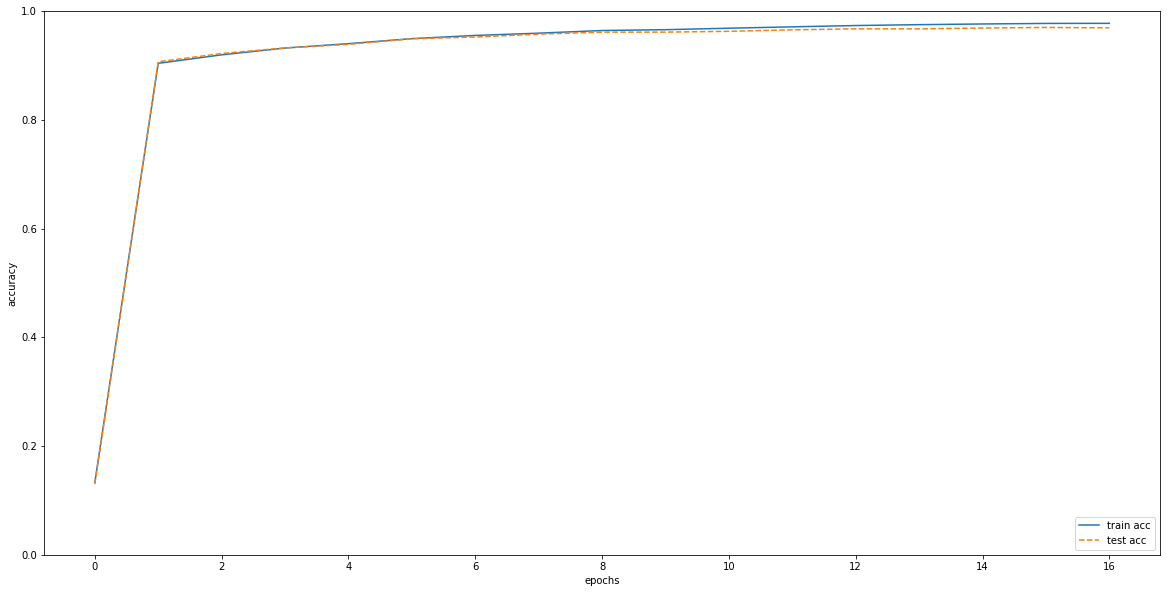

In [ ]:
#@title Main Function
(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size,1)
for i in range(iters_num):
  # 生成batch
  batch_mask = np.random.choice(train_size,batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # grad = network.numerical_gradient(x_batch,t_batch) # 事实证明其效率极低，速度极慢
  grad = network.gradient(x_batch,t_batch)

  for key in ('W1','b1','W2','b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch,t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch == 0: # 每个epoch进行一次评估
    train_acc = network.accuracy(x_train,t_train)
    test_acc = network.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train_acc,test_acc|'+str(train_acc)+','+str(test_acc))

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

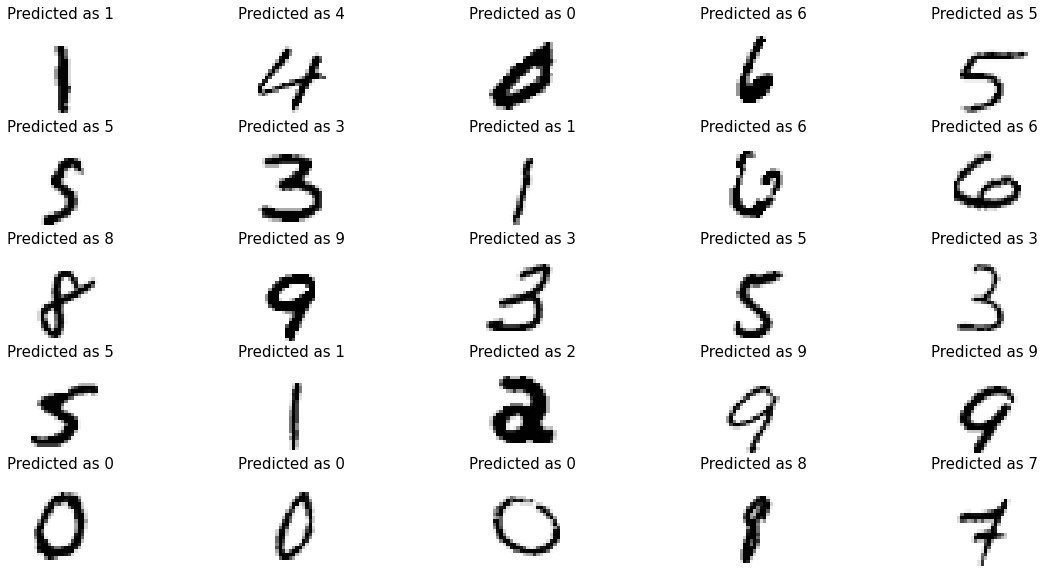

In [ ]:
#@title Visualize our work
alldata = np.vstack([x_train, x_test])
alltarget = np.vstack([t_train, t_test])
rcParams['axes.titlesize'] = 15
rcParams['figure.figsize'] = [20, 10]
for i in range(25):
  index = np.random.choice(x_train.shape[0]+x_test.shape[0],size=1,replace=True) # random pick
  ax = plt.subplot(5, 5, i+1)
  ax.matshow(alldata[index].reshape(28,-1),vmin = 0, vmax = 1, interpolation = 'none', cmap = 'Greys')
  plt.title('Predicted as %d' % np.argmax(alltarget[index]))
  plt.axis('off')
plt.show()


##**Cat v.s. Dog (CNN)**

In [ ]:
#@title Download data
import os, requests
import zipfile

for i in ('train','test'):
  if i == 'train':
    url = "https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1599651957&Signature=aNufIwQLgUsafFGDP%2BNwssEqGKAGcLnIJz0typs48J4YAzuNYgCf%2B%2FETiD4bxppV5ItPzBIH3pZQhqxBVqNtWCfiiPAGC1Q95UEFcjkr2B3FVGgpSgcSFOcWxH0PgXpeRxVoC2BeuhQsGZjnpEfx9fjUDPD7FP0Vd20roNPygeasb5RD%2BNwll4p4v4PgML4vs9S4hdyGAV6mCUEsRBZoj1h8%2B%2BhEFr2%2BKtPc6wyJhPc3JGDEMMOrMht2cdI5ZHdMPpjdZloA2yuNoAeV1IBKbLNCByfXuORE%2FD1wZvzNViyeUL1RrgGOO5WZAKJxteJEOdBNp1qWZ12QnLXZoga90w%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
  else:
    url = 'https://storage.googleapis.com/kagglesdsdata/competitions/3362/31148/test1.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1599652231&Signature=a9WCosnZull0OnhwSqAtwjGalGgH%2Beaj0PAlcr%2B6SqGcfgrQ8E%2BEFkIzRtHh0PwT97L0vBP%2BIWmnSP6Ufpgy%2FqugHpi3Yta1waDjxV5Vn9mQn4v1w7ic%2Fu6o1VTS9nFtqjFWzNdpfXIr2sxYMpQPY0WYYpewHiDVLc1cWxYVq13WNhP9so6k%2Bf1xRGH7nz53X09TA85hXBA8BNRErw6diethaysoyQYi9nXgeRw9q2sGbT%2FbhFhf7OfOnm0dCRWh38QB%2B8VEDeslClERA8hnk3F62aVwwchAE3HZelTfJnkABp2Kz7SAciUMsw4myhu%2BxlN%2F8Cd%2FPf62OE41fg4VBA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtest1.zip'
  fname = 'cat_dog_' + i + '.zip'
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname, "wb") as fid:
          fid.write(r.content)
  extracting = zipfile.ZipFile(fname)
  extracting.extractall()

In [ ]:
#@title A Way to use TensorFlow
#os模块提供了很多操作系统的功能接口函数
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from keras import regularizers
print(tf.__version__)

#训练集和测试集的位置，本地运行的时候记得修改路径
data_dir = '/content'
train_dir = data_dir + '/train/'

test_dir = data_dir + '/test1/'

train_sort_file = [train_dir + filename for filename in os.listdir(train_dir)]
train_sort_file.sort()
train_num = len(train_sort_file)
train_label_gen = np.hstack([np.zeros(train_num // 2),np.ones(train_num // 2)])

X_train, X_target, y_train, y_target = train_test_split(train_sort_file, train_label_gen, 
              test_size = 0.2, random_state = 2020)
train_filenames , train_labels= tf.constant(X_train) , tf.constant(y_train)
test_filenames , test_labels= tf.constant(X_target) , tf.constant(y_target)


#定义解码函数
def _decode_and_resize(filename, label):
    image_string = tf.io.read_file(filename)            # 读取原始文件
    image_decoded = tf.image.decode_jpeg(image_string)  # 解码JPEG图片
    image_resized = tf.image.resize(image_decoded, [256, 256]) / 255.0 #进行归一化
    return image_resized, label

batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels))
#使用map来优化数据集传入性能，num_parallel_calls实现并行
train_dataset = train_dataset.map(
    map_func=_decode_and_resize, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)


# 取出前buffer_size个数据放入buffer，并从其中随机采样，采样后的数据用后续数据替换
train_dataset = train_dataset.shuffle(buffer_size=5000)    

train_dataset = train_dataset.repeat(count=3)

train_dataset = train_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, test_labels))
test_dataset = test_dataset.map(_decode_and_resize)
test_dataset = test_dataset.batch(batch_size)

#这里我们用子类模型构建神经网络，通过结果我们可以发现测试集的效果并不理想，最主要的原因就是这里的网络结构，
#但是因为我无法使用gpu，所以没法给出其他网络的效果，大家可以自己试试别的经典分类网络如VGG16，Resnet等
class CNNModel(tf.keras.models.Model):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(8, 5, activation='relu')
        self.maxpool1 = tf.keras.layers.MaxPooling2D()
        self.conv2 = tf.keras.layers.Conv2D(16, 3, activation='relu')
        self.maxpool2 = tf.keras.layers.MaxPooling2D()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(24, activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='softmax') #sigmoid 和softmax

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)       
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

learning_rate = 0.001
model = CNNModel()
#损失函数
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
#优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#训练集的评估函数
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
#测试集
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

EPOCHS=10
for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_dataset:
        train_step(images, labels)

    for test_images, test_labels in test_dataset:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100
                         ))


###**One Good Example**

https://blog.csdn.net/weixin_43906937/article/details/104874470

In [ ]:
import os,shutil

#解压该目录的文件（训练集照片，25000猫狗图像）
original_dataset_dir = '/content/train'

#在指定路径下创建文件夹
base_dir = '/content/my_catdog_data'
os.mkdir(base_dir) #创建目录
# shutil.rmtree( base_dir ) #删除目录

In [ ]:
#创建训练集，验证集，测试集文件夹
train_dir = os.path.join(base_dir,'train_set')#用于拼接文件的路径
os.mkdir(train_dir)#创建目录
validation_dir = os.path.join(base_dir,'validation_set')#连接目录与文件名
os.mkdir(validation_dir)#创建目录
test_dir = os.path.join(base_dir,'test_set')
os.mkdir(test_dir)

#在这三个文件夹中分别创建猫，狗文件夹
train_cats_dir = os.path.join(train_dir,'cat')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir,'dog')
os.mkdir(train_dogs_dir)
validation_cats_dir = os.path.join(validation_dir,'cat')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir,'dog')
os.mkdir(validation_dogs_dir)
test_cats_dir = os.path.join(test_dir,'cat')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir,'dog')
os.mkdir(test_dogs_dir)

In [ ]:
num = 500
#将前 2*num 张狗的图像复制到train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)#src=原始数据中的dogi.jpg
    dst = os.path.join(train_dogs_dir,fname)#dst=小型猫狗数据集\训练集\狗\dogi.jpg
    shutil.copyfile(src,dst)#将src复制为dst
#将接下来 num 张狗的图像复制到validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(2*num,3*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_dogs_dir,fname)
    shutil.copyfile(src,dst)
#将接下来 num 张狗的图像复制到test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(3*num,4*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_dogs_dir,fname)
    shutil.copyfile(src,dst)

#将前 2*num 张猫的图像复制到train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(train_cats_dir,fname)
    shutil.copyfile(src,dst)
#将接下来 num 张猫的图像复制到validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(2*num,3*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(validation_cats_dir,fname)
    shutil.copyfile(src,dst)
#将接下来 num 张猫的图像复制到test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(3*num,4*num)]
for fname in fnames:
    src = os.path.join(original_dataset_dir,fname)
    dst = os.path.join(test_cats_dir,fname)
    shutil.copyfile(src,dst)

In [ ]:
print('训练集猫的图片：',len(os.listdir(train_cats_dir)))
print('训练集狗的图片：',len(os.listdir(train_dogs_dir)))
print('验证集猫的图片：',len(os.listdir(validation_cats_dir)))
print('验证集狗的图片：',len(os.listdir(validation_dogs_dir)))
print('测试集猫的图片：',len(os.listdir(test_cats_dir)))
print('测试集狗的图片：',len(os.listdir(test_dogs_dir)))

训练集猫的图片： 1000
训练集狗的图片： 1000
验证集猫的图片： 500
验证集狗的图片： 500
测试集猫的图片： 500
测试集狗的图片： 500


In [ ]:
#构建网络
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',
                        input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add((layers.Flatten()))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

from keras import  optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
#数据预处理
#使用ImageDataGenerator从目录中读取图像
from keras.preprocessing.image import ImageDataGenerator
train_dir='/content/my_catdog_data/train_set'
validation_dir='/content/my_catdog_data/validation_set'
#将图像除以225缩放
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,#读取文件的目录（训练集）
    target_size=(150,150),#将所有图像调整为150*150
    batch_size=20,#每个批量包含20个样本
    class_mode='binary'#使用二进制标签
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),#将所有图像调整为150*150
    batch_size=20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#利用批量生成器拟合模型
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6912 - acc: 0.5340 - val_loss: 0.6768 - val_acc: 0.6130
Epoch 2/30
100/100 [==============================] - 9s 92ms/step - loss: 0.6600 - acc: 0.6170 - val_loss: 0.6322 - val_acc: 0.6430
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6085 - acc: 0.6615 - val_loss: 0.6212 - val_acc: 0.6410
Epoch 4/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5717 - acc: 0.7075 - val_loss: 0.5882 - val_acc: 0.6830
Epoch 5/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5487 - acc: 0.7090 - val_loss: 0.5868 - val_acc: 0.6820
Epoch 6/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5175 - acc: 0.7590 - val_loss: 0.5821 - val_acc: 0.6820
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4939 - acc: 0.7585 - val_loss: 0.5639 - val_acc: 0.7030
Epoch 8/30
100/100 [==============================] - 9s 95ms/step - 

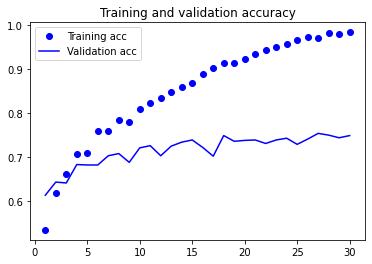

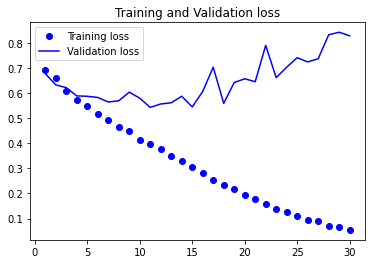

In [ ]:
#绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
#利用ImageDataGenerator来设置数据增强
datagen = ImageDataGenerator(
    rotation_range=40,#表示图像随机旋转的角度范围
    width_shift_range=0.2,#图像在水平方向上平移的范围
    height_shift_range = 0.2,#图像在垂直方向上平移的范围
    shear_range=0.2,#随机错切变换的角度
    zoom_range=0.2,#图像随机缩放的范围
    horizontal_flip=True,#随即将一半图像水平翻转
    fill_mode='nerest'#填充新创建像素的方法
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 18s 181ms/step - loss: 0.6945 - acc: 0.5015 - val_loss: 0.6887 - val_acc: 0.5060
Epoch 2/100
100/100 [==============================] - 18s 177ms/step - loss: 0.6902 - acc: 0.5225 - val_loss: 0.6704 - val_acc: 0.5940
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.6811 - acc: 0.5745 - val_loss: 0.6594 - val_acc: 0.6200
Epoch 4/100
100/100 [==============================] - 17s 174ms/step - loss: 0.6663 - acc: 0.5990 - val_loss: 0.6466 - val_acc: 0.6170
Epoch 5/100
100/100 [==============================] - 17s 175ms/step - loss: 0.6488 - acc: 0.6330 - val_loss: 0.6256 - val_acc: 0.6330
Epoch 6/100
100/100 [==============================] - 18s 183ms/step - loss: 0.6454 - acc: 0.6335 - val_loss: 0.6107 - val_acc: 0.6590
Epoch 7/100
100/100 [==============================] - 18s 184ms/step - loss: 0.6235 - acc: 0.6530 -

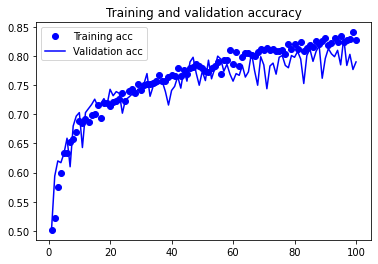

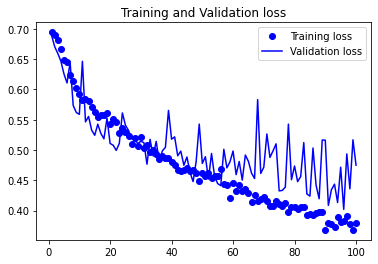

In [ ]:
#定义一个包含dropout的新卷积神经网络
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',
                        input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add((layers.Conv2D(128,(3,3),activation='relu')))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
from keras import  optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#利用数据增强生成器训练卷积神经网络
train_dir='/content/my_catdog_data/train_set'
validation_dir='/content/my_catdog_data/validation_set'
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)
validation_generator=test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

#保存模型
model.save('cats_and_dogs_small_2.h5')
#绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label ='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()
